In [1]:
import lightgbm as lgbm
from hyperopt import hp, tpe, Trials

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import feature_importances,initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score,feature_imp_lgbm
import pickle

In [3]:
prepos= preprocessing()
df_credit_application = prepos.read_data("credit_applications.csv")
df_customers = prepos.read_data("customers.csv")
df_customers.drop("Unnamed: 0",axis=1,inplace=True)
df_credit_application.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
df_complete_data = df_customers.merge(df_credit_application,how="inner",on=["client_nr","yearmonth"])
print(df_complete_data.shape)

(29996, 12)


##### EDA And feature importances

In [5]:
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications
count,29996.000000,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000,29996.000000
mean,481.560775,201493.675157,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509,0.087078
std,281.317753,77.361645,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906,0.364473
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000,0.000000
25%,237.000000,201409.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000,0.000000
50%,479.000000,201505.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000,0.000000
75%,721.000000,201601.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000,0.000000
max,1000.000000,201608.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000,7.000000


<Axes: xlabel='credit_application', ylabel='count'>

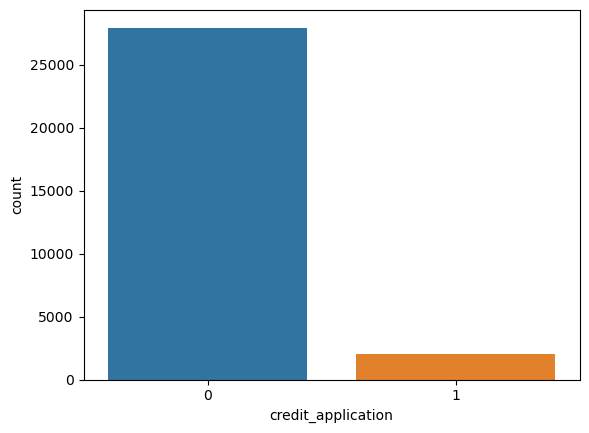

In [6]:
sns.countplot(x=df_complete_data["credit_application"])

# 0    27971
# 1     2025

In [7]:
prepos.missing_values_intable(df_complete_data)

,Missing Values,Percentage of missing values
client_nr,0,0.000000
yearmonth,0,0.000000
total_nr_trx,0,0.000000
nr_debit_trx,0,0.000000
volume_debit_trx,0,0.000000
nr_credit_trx,0,0.000000
volume_credit_trx,0,0.000000
min_balance,0,0.000000
max_balance,0,0.000000
CRG,5537,18.459128


In [8]:
# plt.rcParams["figure.figsize"] = [5,5]  #set the graph to a smaller size 
df_complete_data["debit_credit_ratio"]=df_complete_data["volume_debit_trx"]/df_complete_data["volume_credit_trx"]

In [9]:
df_complete_data["debit_credit_ratio"] = np.where(df_complete_data["debit_credit_ratio"]==np.inf,df_complete_data["volume_debit_trx"],df_complete_data["debit_credit_ratio"])

In [10]:
corl= df_complete_data.corr()
corl["credit_application"].sort_values(ascending=False)

credit_application        1.000000
nr_credit_applications    0.887960
CRG                       0.104958
nr_debit_trx              0.030467
client_nr                 0.020659
volume_credit_trx         0.013168
volume_debit_trx          0.008674
total_nr_trx             -0.001848
debit_credit_ratio       -0.002477
yearmonth                -0.011546
nr_credit_trx            -0.011643
max_balance              -0.043633
min_balance              -0.082577
Name: credit_application, dtype: float64

In [11]:
# fimp=feature_importances()
# X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
# print(accepted_columns)
# print(assoc_result["credit_application"].sort_values(ascending=False))

df_complete_data.drop("nr_credit_applications",axis=1,inplace=True)
fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = fimp.filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

Removing columns: []
['min_balance', 'CRG', 'credit_application']
credit_application    1.00
CRG                   0.13
min_balance           0.08
max_balance           0.04
nr_debit_trx          0.03
client_nr             0.02
yearmonth             0.01
volume_debit_trx      0.01
nr_credit_trx         0.01
volume_credit_trx     0.01
total_nr_trx          0.00
debit_credit_ratio    0.00
Name: credit_application, dtype: float64


For a Time being delete rows where CRG is not present

In [12]:
df_complete_data[df_complete_data["CRG"].isna()]["credit_application"].value_counts()
# 0    5395
# 1     142

0    5395
1     142
Name: credit_application, dtype: int64

In [13]:
df_complete_data = df_complete_data[~df_complete_data["CRG"].isna()]

In [14]:
df_complete_data.shape

(24459, 12)

#### To do : Missing value treatment for CRG

In [15]:
df_complete_data.groupby(["client_nr","yearmonth","CRG"])["total_nr_trx"].count().reset_index()

,client_nr,yearmonth,CRG,total_nr_trx
0,1,201401,1.0,1
1,1,201402,1.0,1
2,1,201403,1.0,1
3,1,201404,1.0,1
4,1,201405,1.0,1
...,...,...,...,...
24454,988,201604,3.0,1
24455,988,201605,3.0,1
24456,988,201606,3.0,1
24457,988,201607,3.0,1


###### New features ideas
Calculate how many times client has applied for credit in the past for each month

In [16]:
def calculate_nr_credit_in_past(current_index):
#     print(current_index)
    client_nr = df_complete_data.loc[[current_index]]["client_nr"].values[0]
    tmp_sum = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].sum()
    tmp_cnt = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].count()
    if(tmp_cnt==0):
        return 0
    else:
        return tmp_sum/tmp_cnt
    
    


In [17]:
df_complete_data["credit_applied_before_ratio"]= df_complete_data.index.map(calculate_nr_credit_in_past)

 ###### Is_debit_more_average
 
 Is volume_debit_trx is more than the average of the volume_debit_trx for that client
 If yes 1 else 0

In [18]:
# debit_average_per_client = df_complete_data.groupby(["client_nr"]).mean()["volume_debit_trx"].reset_index()
# df_complete_data["debit_average_per_client"] = df_complete_data["client_nr"].apply(lambda x: debit_average_per_client[debit_average_per_client["client_nr"]==x]["volume_debit_trx"].values[0])
# df_complete_data["Is_debit_more_average"]=np.where(df_complete_data["debit_average_per_client"] < df_complete_data["volume_debit_trx"],1,0)
# df_complete_data.drop(["debit_average_per_client"],axis=1,inplace=True)

#### Split data strategy

As part of train/test data split, 20% of data will be reserved as test data and will not seen by any model.
That amounts to approximately = 6 months worth of data.
Instead of splitting train/test data randomly, I decided to leave last 6 month data as test data set i.e. March 2016 to August 2016

In [19]:
X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_test = X_test["credit_application"]

X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
y_train_org = X_train_org["credit_application"]

X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

X_test.drop(["credit_application"],axis=1,inplace=True)
X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)


# X_test.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train_org.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_train.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)
# X_val.drop(["credit_application","client_nr","nr_credit_applications"],axis=1,inplace=True)

##### 2. Using Lightgbm feature importance

In [20]:
from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV
params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }


In [21]:
# params_scope = {
# #                 'learning_rate': [x/1000 for x in range(1, 110,10)],
#                 'n_estimators': [x for x in range(10, 500,50)],
#                'num_leaves': [x for x in range(2, 15,2)],
#                'scale_pos_weight':[x for x in range(85, 100,5)],
#                'objective': ['binary'],
# #                'reg_lambda ': [x for x in range(10, 100,10)],
#                }

# import lightgbm as lgb
# model = lgb.LGBMClassifier(**params_scope)
# grid = GridSearchCV(model, param_grid=params_scope, verbose=1, cv=3, n_jobs=-1)
# # Run the grid
# grid.fit(X_train,y_train)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)
# model = grid.best_estimator_
# feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
#                    'feature_importance':model.feature_importances_},
            
#             )
# feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

In [22]:
model,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
                   'feature_importance':model.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|██████████████████████████████████████████████| 250/250 [04:56<00:00,  1.19s/trial, best loss: 0.7510373443983402]


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [23]:
print(initial_params)
feature_imp_df

{'learning_rate': 0.003772953794191604, 'max_bin': 160.0, 'n_estimators': 370.0, 'num_leaves': 5.0, 'pos_bagging_fraction': 0.911798234988362, 'reg_lambda': 37.4936076438315, 'scale_pos_weight': 15.0}


,feature_name,feature_importance
10,credit_applied_before_ratio,369
8,CRG,340
6,min_balance,272
2,nr_debit_trx,168
9,debit_credit_ratio,104
0,yearmonth,92
1,total_nr_trx,68
3,volume_debit_trx,25
7,max_balance,24
4,nr_credit_trx,14


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


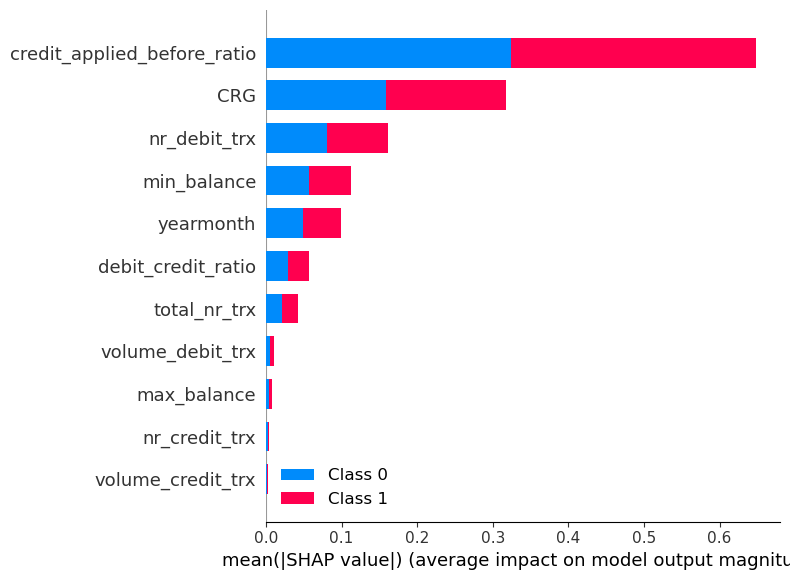

In [24]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")

In [25]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve

# kfolds = StratifiedKFold(5)
# current_f1_scores=[]
# roc_auc_scores_val=[]
# precision_score_val=[]
# recall_score_val=[]
# fpr_scores=[]
# tpr_scores=[]
# mean_roc_auc_scores_val = []
# mean_precision_scores_val = []
# mean_recall_scores_val = []
# mean_f1_scores_val = []

# for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
#     model.fit(
#                 X_train_org.iloc[train_idx],
#                 y_train_org.iloc[train_idx],
#                eval_metric=lgb_f1_score
#             )
#     y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >0.4,1,0)
#     current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
#     tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
#     print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
#     roc_auc_scores_val.append(roc_auc_score(y_true=y_train_org.iloc[val_index], y_score=y_pred))
#     precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
#     recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
#     fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
#     fpr_scores.append(fpr_val)
#     tpr_scores.append(tpr_val)
    
    

In [56]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve

def cross_validation(model,X_train_org,y_train_org,threshold):
    
    kfolds = StratifiedKFold(5)
    current_f1_scores=[]
    roc_auc_scores_val=[]
    precision_score_val=[]
    recall_score_val=[]
    fpr_scores=[]
    tpr_scores=[]

    
    
    for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
        model.fit(
                    X_train_org.iloc[train_idx],
                    y_train_org.iloc[train_idx]
#                   ,eval_metric=lgb_f1_score
                )
        y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >threshold,1,0)
        current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
        tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
        print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
        print(y_pred)
        roc_auc_scores_val.append(roc_auc_score(y_train_org.iloc[val_index], y_pred))
        precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
        fpr_scores.append(fpr_val)
        tpr_scores.append(tpr_val)
    
    return current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores

    

def plot_roc(fpr,tpr,roc_auc,color_ip):
    print('ROC AUC=%0.2f'%roc_auc)
    plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc,color=color_ip)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
#     plt.show()

In [27]:
current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model,X_train_org,y_train_org,0.4)

[[2140 1528]
 [  78  234]]
[0 0 0 ... 1 0 1]
[[2027 1640]
 [  89  223]]
[0 0 0 ... 0 1 1]
[[2056 1611]
 [  72  240]]
[0 0 0 ... 1 1 1]
[[1516 2151]
 [  65  247]]
[1 1 1 ... 1 1 0]
[[1555 2112]
 [  52  260]]
[0 0 0 ... 0 0 0]


ROC AUC=0.67
ROC AUC=0.63
ROC AUC=0.66
ROC AUC=0.60
ROC AUC=0.63
Mean ROC AUC score on validation data =0.64


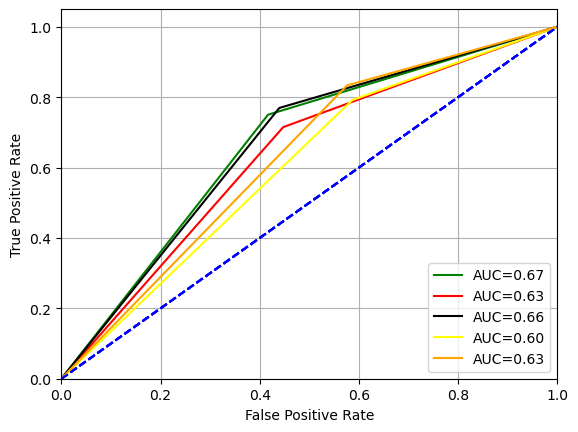

In [28]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [29]:
def print_metrics(f1_scores,recall_scores,precision_scores,dataset="validation"):
    print("F1 scores on "+ dataset+" data:")
    print(f1_scores)
    print("-----------------------------------------------------")
    print("Recall scores on "+ dataset+" data:")
    print(recall_scores)
    print("-----------------------------------------------------")
    print("Mean f1 score on "+ dataset+" data:")
    print(np.mean(f1_scores))

    print("-----------------------------------------------------")
    print("Mean recall score on "+ dataset+" data:")
    print(np.mean(recall_scores))

    print("-----------------------------------------------------")
    print("Mean precision score on "+ dataset+" data:")
    print(np.mean(precision_scores))

In [30]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22565091610414656, 0.20505747126436782, 0.2219140083217753, 0.18228782287822878, 0.19374068554396426]
-----------------------------------------------------
Recall scores on validation data:
[0.75, 0.7147435897435898, 0.7692307692307693, 0.7916666666666666, 0.8333333333333334]
-----------------------------------------------------
Mean f1 score on validation data:
0.20573018082249656
-----------------------------------------------------
Mean recall score on validation data:
0.7717948717948718
-----------------------------------------------------
Mean precision score on validation data:
0.11895546579284852


###### On test data

In [31]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1113 3127]
 [  17  306]]
F1 score on Test data:
0.16293929712460062
-----------------------------------------------------
Recall score on Test data:
0.9473684210526315
-----------------------------------------------------
Precision score on Test data:
0.08913486746286048
---------------THRESHOLD =0.35 ----------------------
[[2079 2161]
 [  53  270]]
F1 score on Test data:
0.19607843137254902
-----------------------------------------------------
Recall score on Test data:
0.8359133126934984
-----------------------------------------------------
Precision score on Test data:
0.11106540518305225
---------------THRESHOLD =0.4 ----------------------
[[2158 2082]
 [  55  268]]
F1 score on Test data:
0.20052375607931164
-----------------------------------------------------
Recall score on Test data:
0.8297213622291022
-----------------------------------------------------
Precision score on Test data:
0.11404255319148936
---------------THR

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [32]:
# X_test=X_test[X_train.columns]
y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >0.4,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2158 2082]
 [  55  268]]
F1 score on Test data:
0.20052375607931164
-----------------------------------------------------
Recall score on Test data:
0.8297213622291022
-----------------------------------------------------
Precision score on Test data:
0.11404255319148936


In [34]:
### Save preds to csv file

X_test["ground_truth"] = y_test
X_test["pred_lgbm"]=y_test_pred
X_test.to_csv("output files/predictions_on_test_set_lgbm.csv")


In [35]:
pickle.dump(model,open('output files/model_lgbm','wb'))
    

###### SVM 

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
std=StandardScaler()
Xformed_data = std.fit_transform(X_train_org)

In [ ]:
Xformed_data = pd.DataFrame(Xformed_data,columns=X_train_org.columns)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
def svm_hyper(X_train_transformed, y_train):
    svc = SVC()
    C_range = [0.001,0.1,1,10]
#     gamma_range = [0.001,0.1,1,'scale', 'auto']    
    param_grid = { 
        "C": C_range,
        "kernel": ['rbf', 'poly']
#         ,"gamma": gamma_range
        }
    print(param_grid)
    scoring = ['f1']
#     kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    random_search = RandomizedSearchCV(estimator=svc, 
                               param_distributions=param_grid, 
                               n_iter=5,
                               scoring=scoring,
                               refit="f1",        
                               n_jobs=-1, 
                               cv=3)
    # Fit grid search
    random_result = random_search.fit(X_train_transformed, y_train)
    # Print grid search summary
    model = random_search.best_estimator_
    return model,random_search

In [ ]:
model,random_search = svm_hyper(Xformed_data,y_train_org)

In [ ]:
import pickle
# pickle.dump(model,open("output files/model_svm.pkl","wb"))
model_svm = pickle.load(open("output files/model_svm.pkl","rb"))


In [ ]:
y_test_pred = model_svm.predict(X_test[X_train.columns])
print(confusion_matrix(y_test_pred,y_test))
print(f1_score(y_test_pred,y_test))

###### Random forest 

In [36]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score,RandomizedSearchCV


In [47]:
# from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10],
 'bootstrap': [True, False]}

In [51]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_rf = BalancedRandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train_org, y_train_org)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [52]:
model_rf=rf_random.best_estimator_

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
        
    current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model_rf,X_train_org,y_train_org,0.45)

[[2027 1641]
 [  70  242]]
[0 0 0 ... 0 0 1]
[[1918 1749]
 [  84  228]]
[0 0 0 ... 1 1 1]
[[1878 1789]
 [  73  239]]
[0 0 0 ... 0 1 1]
[[1471 2196]
 [  62  250]]
[1 1 1 ... 1 1 0]
[[1480 2187]
 [  49  263]]
[0 0 0 ... 0 0 0]


ROC AUC=0.66
ROC AUC=0.63
ROC AUC=0.64
ROC AUC=0.60
ROC AUC=0.62
Mean ROC AUC score on validation data =0.63


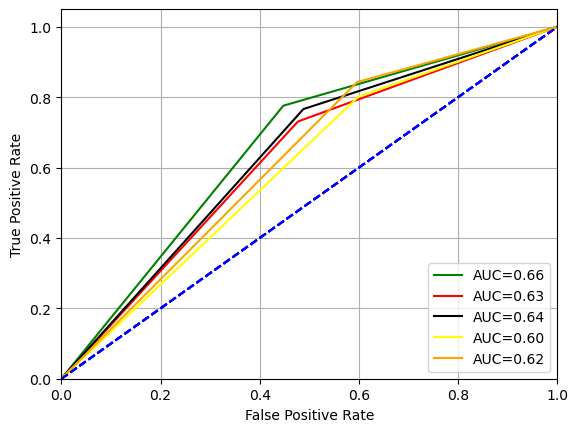

In [58]:
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [59]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22050113895216397, 0.19921363040629098, 0.2042735042735043, 0.18129079042784624, 0.19044170890658943]
-----------------------------------------------------
Recall scores on validation data:
[0.7756410256410257, 0.7307692307692307, 0.7660256410256411, 0.8012820512820513, 0.842948717948718]
-----------------------------------------------------
Mean f1 score on validation data:
0.199144154593279
-----------------------------------------------------
Mean recall score on validation data:
0.7833333333333334
-----------------------------------------------------
Mean precision score on validation data:
0.11424985942730267


In [60]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1207 3033]
 [  21  302]]
F1 score on Test data:
0.1651175505740842
-----------------------------------------------------
Recall score on Test data:
0.934984520123839
-----------------------------------------------------
Precision score on Test data:
0.09055472263868065
---------------THRESHOLD =0.35 ----------------------
[[1702 2538]
 [  30  293]]
F1 score on Test data:
0.18579581483830057
-----------------------------------------------------
Recall score on Test data:
0.9071207430340558
-----------------------------------------------------
Precision score on Test data:
0.10349699752737548
---------------THRESHOLD =0.4 ----------------------
[[2007 2233]
 [  46  277]]
F1 score on Test data:
0.19555241793152134
-----------------------------------------------------
Recall score on Test data:
0.8575851393188855
-----------------------------------------------------
Precision score on Test data:
0.11035856573705179
---------------THRES

In [61]:

y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >0.5,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2430 1810]
 [  79  244]]
F1 score on Test data:
0.20530079932688264
-----------------------------------------------------
Recall score on Test data:
0.7554179566563467
-----------------------------------------------------
Precision score on Test data:
0.11879259980525804


In [62]:
### Save preds to csv file

# X_test["ground_truth"] = y_test
X_test["pred_rf"]=y_test_pred
X_test.to_csv("output files/predictions_on_test_set_rf_threshold_0.5.csv")


pickle.dump(model,open("output files/model_rf.pkl","wb"))

##### Unsupervised (Isolation forest)

In [63]:

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,recall_score,precision_score

In [64]:
model_iso = IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,n_estimators=230)
model_iso.fit(X_train_org)

X does not have valid feature names, but IsolationForest was fitted with feature names


IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,
                n_estimators=230)

In [65]:
model_iso.predict(X_test[X_train.columns])
y_test_pred = model_iso.predict(X_test[X_train.columns])
y_test_pred = [1 if x==-1 else 0 for x in y_test_pred ]
score = f1_score(y_test, y_test_pred)

In [66]:
print(score)
print(recall_score(y_test, y_test_pred))

0.0881226053639847
0.07120743034055728


In [67]:
X_test["iso_pred"]=y_test_pred

##### Ensemble voting

[[2430 1810]
 [  79  244]]

In [69]:
X_test["final_pred"]=np.where(X_test["pred_lgbm"]+X_test["pred_rf"]+X_test["iso_pred"]>1,1,0)

[[2447 1793]
 [  79  244]]
0.7554179566563467


In [70]:
print(f1_score(X_test["ground_truth"],X_test["final_pred"]))
print(recall_score(X_test["ground_truth"],X_test["final_pred"]))
print(precision_score(X_test["ground_truth"],X_test["final_pred"]))
confusion_matrix(X_test["ground_truth"],X_test["final_pred"])

0.20677966101694914
0.7554179566563467
0.11978399607265587


array([[2447, 1793],
       [  79,  244]], dtype=int64)

In [ ]:
# print(f1_score(X_test["ground_truth"],X_test["pred_lgbm"]))
# print(recall_score(X_test["ground_truth"],X_test["pred_lgbm"]))
# print(precision_score(X_test["ground_truth"],X_test["pred_lgbm"]))
# confusion_matrix(X_test["ground_truth"],X_test["pred_lgbm"])

In [71]:
X_test.to_csv("output files/ensemble_voting.csv")
pickle.dump(model_iso,open('output files/model_iso.pkl','wb'))